# Proyecto 200Eng - Black list

Transferencia a servidor



### Importa dependencias

In [85]:
# pip install pymysql

In [86]:
#importa dependencias
from pymysql import connect
import pandas as pd
from datetime import datetime, date, time, timedelta
from time import sleep
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns
from millify import millify, prettify
import os
from sqlalchemy import create_engine
import plotly.express as px
import random


In [87]:
round(random.random(), 2)

0.94

In [88]:
datetime.now()

datetime.datetime(2024, 9, 24, 1, 6, 26, 144623)

In [89]:
datetime.now().hour

1

In [90]:
date(2024, 8, 18) == datetime(2024, 8, 18, 0, 0, 0)

False

In [91]:
datetime.now() - timedelta(days=30)

datetime.datetime(2024, 8, 25, 1, 6, 26, 188391)

In [92]:
start = datetime.now()
sleep(3)
end = datetime.now()
elapsed = end - start
print(str(elapsed).split(':'))

['0', '00', '03.000407']


### Conexión con todos los marcadores

In [93]:
# lista de marcadores
url_marcadores = ['83.138.55.125',
              '193.219.97.92',
              '193.219.97.90',
              '83.138.55.115',
              '94.177.9.69',
              '83.138.55.163',
              ]

ind_marcadores = [1, 2, 3, 4, 6, 7]

In [94]:
user = 'carlosai'
password = 'OKJmBUIFnh'
port = '3306'
database = 'mbilling'

In [95]:
# creación de un diccionario de bd para cada marcadro con pymysql

def connect_to_db():
    bd = {}
    cursores = {}

    for i, ind in enumerate(ind_marcadores):
        # crea la conexión
        bd[f'marcador_{ind}'] = connect(host = url_marcadores[i],
                                        user=user,
                                        passwd=password,
                                        database=database,
                                        )

        # crea el cursor
        cursores[f'cursor_marcador_{ind}'] = bd[f'marcador_{ind}'].cursor()
    return bd, cursores

bd, cursores = connect_to_db()

bd


{'marcador_1': <pymysql.connections.Connection at 0x7f52d8ad4170>,
 'marcador_2': <pymysql.connections.Connection at 0x7f52d7a7c620>,
 'marcador_3': <pymysql.connections.Connection at 0x7f52d7a4b020>,
 'marcador_4': <pymysql.connections.Connection at 0x7f52d844b2f0>,
 'marcador_6': <pymysql.connections.Connection at 0x7f52e259f470>,
 'marcador_7': <pymysql.connections.Connection at 0x7f52e259c470>}

In [96]:
# creación de un diccionario de bd para cada marcadro con sqlalchemy

bd_sqlalch = {}

for i, ind in enumerate(ind_marcadores):
    # crea la conexión
    cnx = create_engine(f'mysql+pymysql://{user}:{password}@{url_marcadores[i]}:{port}/{database}')
    bd_sqlalch[f'marcador_{ind}'] = cnx.connect()


In [97]:
bd

{'marcador_1': <pymysql.connections.Connection at 0x7f52d8ad4170>,
 'marcador_2': <pymysql.connections.Connection at 0x7f52d7a7c620>,
 'marcador_3': <pymysql.connections.Connection at 0x7f52d7a4b020>,
 'marcador_4': <pymysql.connections.Connection at 0x7f52d844b2f0>,
 'marcador_6': <pymysql.connections.Connection at 0x7f52e259f470>,
 'marcador_7': <pymysql.connections.Connection at 0x7f52e259c470>}

In [98]:
bd_sqlalch

{'marcador_1': <sqlalchemy.engine.base.Connection at 0x7f52f0d27080>,
 'marcador_2': <sqlalchemy.engine.base.Connection at 0x7f52e277e4b0>,
 'marcador_3': <sqlalchemy.engine.base.Connection at 0x7f52d72391c0>,
 'marcador_4': <sqlalchemy.engine.base.Connection at 0x7f52d7405d30>,
 'marcador_6': <sqlalchemy.engine.base.Connection at 0x7f52e252c770>,
 'marcador_7': <sqlalchemy.engine.base.Connection at 0x7f52d7a4b2f0>}

In [99]:
cursores

{'cursor_marcador_1': <pymysql.cursors.Cursor at 0x7f52d77a4c20>,
 'cursor_marcador_2': <pymysql.cursors.Cursor at 0x7f52d7a7e7e0>,
 'cursor_marcador_3': <pymysql.cursors.Cursor at 0x7f52d7c589b0>,
 'cursor_marcador_4': <pymysql.cursors.Cursor at 0x7f52d73695b0>,
 'cursor_marcador_6': <pymysql.cursors.Cursor at 0x7f52e259fc50>,
 'cursor_marcador_7': <pymysql.cursors.Cursor at 0x7f52d7147440>}

### Extracción de datos

In [100]:
# rango de 1 mes
fecha = datetime(2023, 9, 30)
dias = 15
fecha_menos_30 = (fecha - timedelta(days=dias)).strftime('%Y-%m-%d')
start = '2023-01-12'

if start > fecha_menos_30:
    fecha_inicio = start
else:
    fecha_inicio = fecha_menos_30

fecha = fecha.strftime('%Y-%m-%d')

print(f'Fecha de inicio: {fecha_inicio}\nFecha de final: {fecha}')


Fecha de inicio: 2023-09-15
Fecha de final: 2023-09-30


In [101]:
# define la consulta (query)
query = dedent(f"""
        SELECT starttime, calledstation, real_sessiontime
        FROM pkg_cdr
        WHERE starttime BETWEEN '{fecha_inicio}' AND '{fecha}';
        """)

print(f'Query a correr:\n{query}')


Query a correr:

SELECT starttime, calledstation, real_sessiontime
FROM pkg_cdr
WHERE starttime BETWEEN '2023-09-15' AND '2023-09-30';



In [102]:
# crea una función para devolver cada df con pymysql
def get_df(bd, bd_name):
    df_temp = pd.read_sql(query, bd)
    df_temp['bd'] = bd_name

    return df_temp

In [103]:
# crea una función para devolver cada df con sqlalchemy
def get_df_sqlalch(bd, bd_name):
    sql_query = pd.read_sql_query(query, bd)
    df_temp = pd.DataFrame(sql_query)
    df_temp['bd'] = bd_name

    return df_temp

In [104]:
#lista de df
# df_list = [get_df(bd[f'marcador_{ind}'], f'marcador_{ind}') for ind in ind_marcadores]

df_list = []
for ind in ind_marcadores:
    query_ok = False
    conn_ok = False
    print(f'Consultando marcador_{ind}...')
    while not query_ok:
        try:
            df_list.append(get_df(bd[f'marcador_{ind}'], f'marcador_{ind}'))
            query_ok = True
            print(f'Consulta marcador_{ind} OK')
        except:
            print(f'Consulta marcador_{ind} con ERROR')
            while not conn_ok:
                try:
                    bd, _ = connect_to_db()
                    conn_ok = True
                    print(f'Nueva conexión bd OK')
                except:
                    print(f'Nueva conexión bd con ERROR')
                    sleep(5)
        


Consultando marcador_1...


/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Consulta marcador_1 OK
Consultando marcador_2...


/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Consulta marcador_2 OK
Consultando marcador_3...


/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Consulta marcador_3 OK
Consultando marcador_4...


/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Consulta marcador_4 OK
Consultando marcador_6...
Consulta marcador_6 OK
Consultando marcador_7...
Consulta marcador_7 OK


/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

/tmp/ipykernel_31917/2795151752.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [105]:
ind_marcadores

[1, 2, 3, 4, 6, 7]

In [106]:
len(df_list)

6

In [107]:
df_list[2]

,starttime,calledstation,real_sessiontime,bd
0,2023-09-15 07:04:19,18554825956,7,marcador_3
1,2023-09-15 07:04:23,18448718488,7,marcador_3
2,2023-09-15 07:04:14,18559155129,18,marcador_3
3,2023-09-15 07:04:20,18886010413,18,marcador_3
4,2023-09-15 07:04:07,18662938682,38,marcador_3
...,...,...,...,...
514366,2023-09-29 20:59:17,18442071296,2085,marcador_3
514367,2023-09-29 20:59:51,18447756574,2053,marcador_3
514368,2023-09-29 20:59:45,18447699974,2066,marcador_3
514369,2023-09-29 21:00:01,18556169263,2055,marcador_3


In [108]:
df = pd.concat(df_list, axis=0)
df

/tmp/ipykernel_31917/1100062364.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,starttime,calledstation,real_sessiontime,bd
0,2023-09-15 07:00:37,18773499279,6,marcador_1
1,2023-09-15 07:00:31,18776230008,28,marcador_1
2,2023-09-15 07:00:10,18778210984,49,marcador_1
3,2023-09-15 07:00:10,18889323687,50,marcador_1
4,2023-09-15 07:00:53,18667798424,10,marcador_1
...,...,...,...,...
504108,2023-09-29 21:15:16,18008002911,1276,marcador_4
504109,2023-09-29 21:15:27,18006358261,1266,marcador_4
504110,2023-09-29 21:15:26,18889724878,1267,marcador_4
504111,2023-09-29 21:15:11,18884327031,1288,marcador_4


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2187411 entries, 0 to 504112
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   starttime         datetime64[ns]
 1   calledstation     object        
 2   real_sessiontime  object        
 3   bd                object        
dtypes: datetime64[ns](1), object(3)
memory usage: 83.4+ MB


In [110]:
df['weekday'] = df.starttime.dt.weekday
df['hour'] = df.starttime.dt.hour
df

,starttime,calledstation,real_sessiontime,bd,weekday,hour
0,2023-09-15 07:00:37,18773499279,6,marcador_1,4,7
1,2023-09-15 07:00:31,18776230008,28,marcador_1,4,7
2,2023-09-15 07:00:10,18778210984,49,marcador_1,4,7
3,2023-09-15 07:00:10,18889323687,50,marcador_1,4,7
4,2023-09-15 07:00:53,18667798424,10,marcador_1,4,7
...,...,...,...,...,...,...
504108,2023-09-29 21:15:16,18008002911,1276,marcador_4,4,21
504109,2023-09-29 21:15:27,18006358261,1266,marcador_4,4,21
504110,2023-09-29 21:15:26,18889724878,1267,marcador_4,4,21
504111,2023-09-29 21:15:11,18884327031,1288,marcador_4,4,21


In [111]:
df = df.set_index('starttime')
df = df.sort_index()
df

,calledstation,real_sessiontime,bd,weekday,hour
starttime,,,,,
2023-09-15 07:00:03,18775851085,3600,marcador_4,4,7
2023-09-15 07:00:06,18885221986,3610,marcador_4,4,7
2023-09-15 07:00:07,18888576340,20,marcador_4,4,7
2023-09-15 07:00:08,18774228366,1801,marcador_4,4,7
2023-09-15 07:00:10,18882015693,90,marcador_4,4,7
...,...,...,...,...,...
2023-09-29 21:16:41,18008593028,107,marcador_3,4,21
2023-09-29 21:16:44,18778531388,112,marcador_3,4,21
2023-09-29 21:16:44,18882501728,434,marcador_3,4,21


In [112]:
df.memory_usage(deep=True)

Index                17499288
calledstation       131244660
real_sessiontime     78746796
bd                  129057249
weekday               8749644
hour                  8749644
dtype: int64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187411 entries, 2023-09-15 07:00:03 to 2023-09-29 21:16:45
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   calledstation     object
 1   real_sessiontime  object
 2   bd                object
 3   weekday           int32 
 4   hour              int32 
dtypes: int32(2), object(3)
memory usage: 83.4+ MB


In [114]:
df.calledstation = df.calledstation.astype('category')
df.real_sessiontime = df.real_sessiontime.astype('int')
df.bd = df.bd.astype('category')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187411 entries, 2023-09-15 07:00:03 to 2023-09-29 21:16:45
Data columns (total 5 columns):
 #   Column            Dtype   
---  ------            -----   
 0   calledstation     category
 1   real_sessiontime  int64   
 2   bd                category
 3   weekday           int32   
 4   hour              int32   
dtypes: category(2), int32(2), int64(1)
memory usage: 62.9 MB


In [116]:
df.memory_usage(deep=True).sum()

np.int64(68761423)

In [117]:
df.index.nunique()

617088

In [118]:
df.shape

(2187411, 5)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187411 entries, 2023-09-15 07:00:03 to 2023-09-29 21:16:45
Data columns (total 5 columns):
 #   Column            Dtype   
---  ------            -----   
 0   calledstation     category
 1   real_sessiontime  int64   
 2   bd                category
 3   weekday           int32   
 4   hour              int32   
dtypes: category(2), int32(2), int64(1)
memory usage: 95.2 MB


In [120]:
df.nunique().sort_values(ascending=False)

calledstation       53542
real_sessiontime     3683
hour                   15
weekday                 7
bd                      4
dtype: int64

In [121]:
df_dest_calls = df.calledstation.value_counts().to_frame()
df_dest_calls = df_dest_calls.rename(columns={'count': 'num_llamadas'})
df_dest_calls

,num_llamadas
calledstation,
18007976257,84
18884730868,84
18443461495,83
18666359077,82
18888610649,82
...,...
18447500909,1
18557593766,1
18443756922,1


### Análisis de información

In [122]:
df_dest = df.groupby(['calledstation']).real_sessiontime.sum().sort_values(ascending=False).to_frame()
df_dest

/tmp/ipykernel_31917/396288627.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,real_sessiontime
calledstation,
18443103947,197319
18009828522,195049
18003322415,189868
18884905457,187936
18005956286,186138
...,...
18778142461,3
18775826893,2
18449861777,2


In [123]:
df_dest = df_dest.join(df_dest_calls, on='calledstation')
df_dest

,real_sessiontime,num_llamadas
calledstation,,
18443103947,197319,81
18009828522,195049,75
18003322415,189868,80
18884905457,187936,81
18005956286,186138,76
...,...,...
18778142461,3,1
18775826893,2,1
18449861777,2,1


In [124]:
df_dest['dur_prom'] = df_dest.real_sessiontime / df_dest.num_llamadas
df_dest

,real_sessiontime,num_llamadas,dur_prom
calledstation,,,
18443103947,197319,81,2436.037037
18009828522,195049,75,2600.653333
18003322415,189868,80,2373.350000
18884905457,187936,81,2320.197531
18005956286,186138,76,2449.184211
...,...,...,...
18778142461,3,1,3.000000
18775826893,2,1,2.000000
18449861777,2,1,2.000000


In [125]:
df_dest.sort_values(by='num_llamadas', ascending=False)

,real_sessiontime,num_llamadas,dur_prom
calledstation,,,
18884730868,38285,84,455.773810
18007976257,8203,84,97.654762
18443461495,36384,83,438.361446
18666359077,32757,82,399.475610
18443157460,21840,82,266.341463
...,...,...,...
18448238378,13,1,13.000000
18444637149,13,1,13.000000
18449861777,2,1,2.000000


In [126]:
def P5(x):
    return x.quantile(0.05)

def P25(x):
    return x.quantile(0.25)

def P50(x):
    return x.quantile(0.5)

def P75(x):
    return x.quantile(0.75)

def P95(x):
    return x.quantile(0.95)

In [127]:
# %%time
# df_dest_stats = df.groupby('calledstation').aggregate({'real_sessiontime': ['max', 'min', P25, P50, P75]})


In [128]:
# df_dest_stats

In [129]:
# df_dest_stats.columns = df_dest_stats.columns.map('_'.join).str.strip('_')
# df_dest_stats

In [130]:
# df_dest = df_dest.join(df_dest_stats, on='calledstation')
# df_dest

In [131]:
def ratio(df_func, last_n=2):
    df_temp = df_func.tail(last_n)
    ratio = df_temp['real_sessiontime'].std() / df_temp['real_sessiontime'].mean()
    return ratio

In [132]:
df_dest_ratio = df.groupby('calledstation').apply(ratio).to_frame()
df_dest_ratio = df_dest_ratio.rename(columns={0:'flat_ratio'})
df_dest_ratio

/tmp/ipykernel_31917/3051033278.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_31917/3051033278.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,flat_ratio
calledstation,
18002001956,0.016922
18002002000,0.000000
18002002599,0.584201
18002002665,0.015491
18002003111,0.026683
...,...
18889995252,0.690213
18889996569,0.008468
18889999101,0.004447


In [133]:
df_dest = df_dest.join(df_dest_ratio, on='calledstation')
df_dest

,real_sessiontime,num_llamadas,dur_prom,flat_ratio
calledstation,,,,
18443103947,197319,81,2436.037037,0.202349
18009828522,195049,75,2600.653333,0.310040
18003322415,189868,80,2373.350000,0.638697
18884905457,187936,81,2320.197531,1.007097
18005956286,186138,76,2449.184211,0.293285
...,...,...,...,...
18778142461,3,1,3.000000,NaN
18775826893,2,1,2.000000,NaN
18449861777,2,1,2.000000,NaN


In [134]:
umbral = 0.005
df_dest_flat = df_dest[df_dest.flat_ratio <= umbral].sort_values(by='num_llamadas', ascending=False)
df_dest_flat

,real_sessiontime,num_llamadas,dur_prom,flat_ratio
calledstation,,,,
18884730868,38285,84,455.773810,0.002193
18443461495,36384,83,438.361446,0.003143
18666359077,32757,82,399.475610,0.003518
18448165971,14427,80,180.337500,0.002800
18552258400,1466,79,18.556962,0.000000
...,...,...,...,...
18448213248,874,2,437.000000,0.003236
18007154836,116,2,58.000000,0.000000
18448743833,598,2,299.000000,0.004730


In [135]:
index_lm = df_dest_flat.index
index_lm

CategoricalIndex(['18884730868', '18443461495', '18666359077', '18448165971',
                  '18552258400', '18883926621', '18884441424', '18007451700',
                  '18009995425', '18882320403',
                  ...
                  '18554054996', '18448634621', '18447361549', '18667271694',
                  '18772197340', '18448213248', '18007154836', '18448743833',
                  '18004036322', '18444786683'],
                 categories=['18002001956', '18002002000', '18002002599', '18002002665', ..., '18889996569', '18889999101', '18889999353', '18889999520'], ordered=False, dtype='category', name='calledstation', length=10512)

In [136]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2024-09-24 01:08:00'

In [137]:
block_numbers = ''
ind = 0
num_block = 10


while ind < num_block:
    block_numbers += "("
    block_numbers += index_lm[ind]
    block_numbers += ","
    block_numbers += f"'Número agregado por Carlos Gorricho desde script the Python el {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'"
    if ind < num_block - 1:
        block_numbers += "),\n"
    else:
        block_numbers += ")"

    ind += 1


print(block_numbers)


(18884730868,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18443461495,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18666359077,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18448165971,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18552258400,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18883926621,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18884441424,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18007451700,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18009995425,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18882320403,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00')


In [138]:
# define la consulta (query)
add_query = dedent(f"""INSERT INTO `pkg_campaign_restrict_phone` (number, description) VALUES {block_numbers};""")

print(f'Query a correr:\n{add_query}')


Query a correr:
INSERT INTO `pkg_campaign_restrict_phone` (number, description) VALUES (18884730868,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18443461495,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18666359077,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18448165971,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18552258400,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18883926621,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18884441424,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18007451700,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18009995425,'Número agregado por Carlos Gorricho desde script the Python el 2024-09-24 01:08:00'),
(18882320403,

In [139]:
# ejecuta consulta en todos los marcadores
for key in cursores:
    cursores[key].execute(add_query)
    print(f'Ejectando consulta en {key} - Agregadas {cursores[key].rowcount} filas')
    


Ejectando consulta en cursor_marcador_1 - Agregadas 10 filas
Ejectando consulta en cursor_marcador_2 - Agregadas 10 filas
Ejectando consulta en cursor_marcador_3 - Agregadas 10 filas
Ejectando consulta en cursor_marcador_4 - Agregadas 10 filas
Ejectando consulta en cursor_marcador_6 - Agregadas 10 filas
Ejectando consulta en cursor_marcador_7 - Agregadas 10 filas


In [140]:
# compromete los cambios en todos los marcadores
for base in bd:
    bd[base].commit()
    print(f'Condirmando cambios en {base}')
    

Condirmando cambios en marcador_1
Condirmando cambios en marcador_2
Condirmando cambios en marcador_3
Condirmando cambios en marcador_4
Condirmando cambios en marcador_6
Condirmando cambios en marcador_7


### Visualizaciones

#### Flatliners

In [141]:
df

,calledstation,real_sessiontime,bd,weekday,hour
starttime,,,,,
2023-09-15 07:00:03,18775851085,3600,marcador_4,4,7
2023-09-15 07:00:06,18885221986,3610,marcador_4,4,7
2023-09-15 07:00:07,18888576340,20,marcador_4,4,7
2023-09-15 07:00:08,18774228366,1801,marcador_4,4,7
2023-09-15 07:00:10,18882015693,90,marcador_4,4,7
...,...,...,...,...,...
2023-09-29 21:16:41,18008593028,107,marcador_3,4,21
2023-09-29 21:16:44,18778531388,112,marcador_3,4,21
2023-09-29 21:16:44,18882501728,434,marcador_3,4,21


In [142]:
index_lm = df_dest_flat.index
index_lm

CategoricalIndex(['18884730868', '18443461495', '18666359077', '18448165971',
                  '18552258400', '18883926621', '18884441424', '18007451700',
                  '18009995425', '18882320403',
                  ...
                  '18554054996', '18448634621', '18447361549', '18667271694',
                  '18772197340', '18448213248', '18007154836', '18448743833',
                  '18004036322', '18444786683'],
                 categories=['18002001956', '18002002000', '18002002599', '18002002665', ..., '18889996569', '18889999101', '18889999353', '18889999520'], ordered=False, dtype='category', name='calledstation', length=10512)

In [143]:
df_dest_flat.flat_ratio.mean()

np.float64(0.0013934703254885638)

In [144]:
rows=5
cols=5
indice=0
i=0
index_lm[i+indice*rows*cols]

'18884730868'

In [145]:
df_dest.index[i+indice*rows*cols]

'18443103947'

In [146]:
def plot_flat_ts(df, df_graf, ind=0):    
    rows = 5
    cols = 5
    indice = ind
    fix, ax = plt.subplots(rows,cols,
                        figsize=(20,rows * 4),
                        sharey=True,
                        sharex=True,
                        squeeze=False)

    for i in range(rows * cols):
        ax[i//5, i%5].plot(df[df['calledstation']==df_graf.index[i+indice*rows*cols]].real_sessiontime)
        ax[i//5, i%5].set_title(f"{i+1+indice*rows*cols}. {df_graf.index[i+indice*rows*cols]} ({df_graf.loc[df_graf.index[i+indice*rows*cols], 'flat_ratio']:.3f})\n")
        ax[i//5, i%5].set_xticklabels([])

    plt.show()


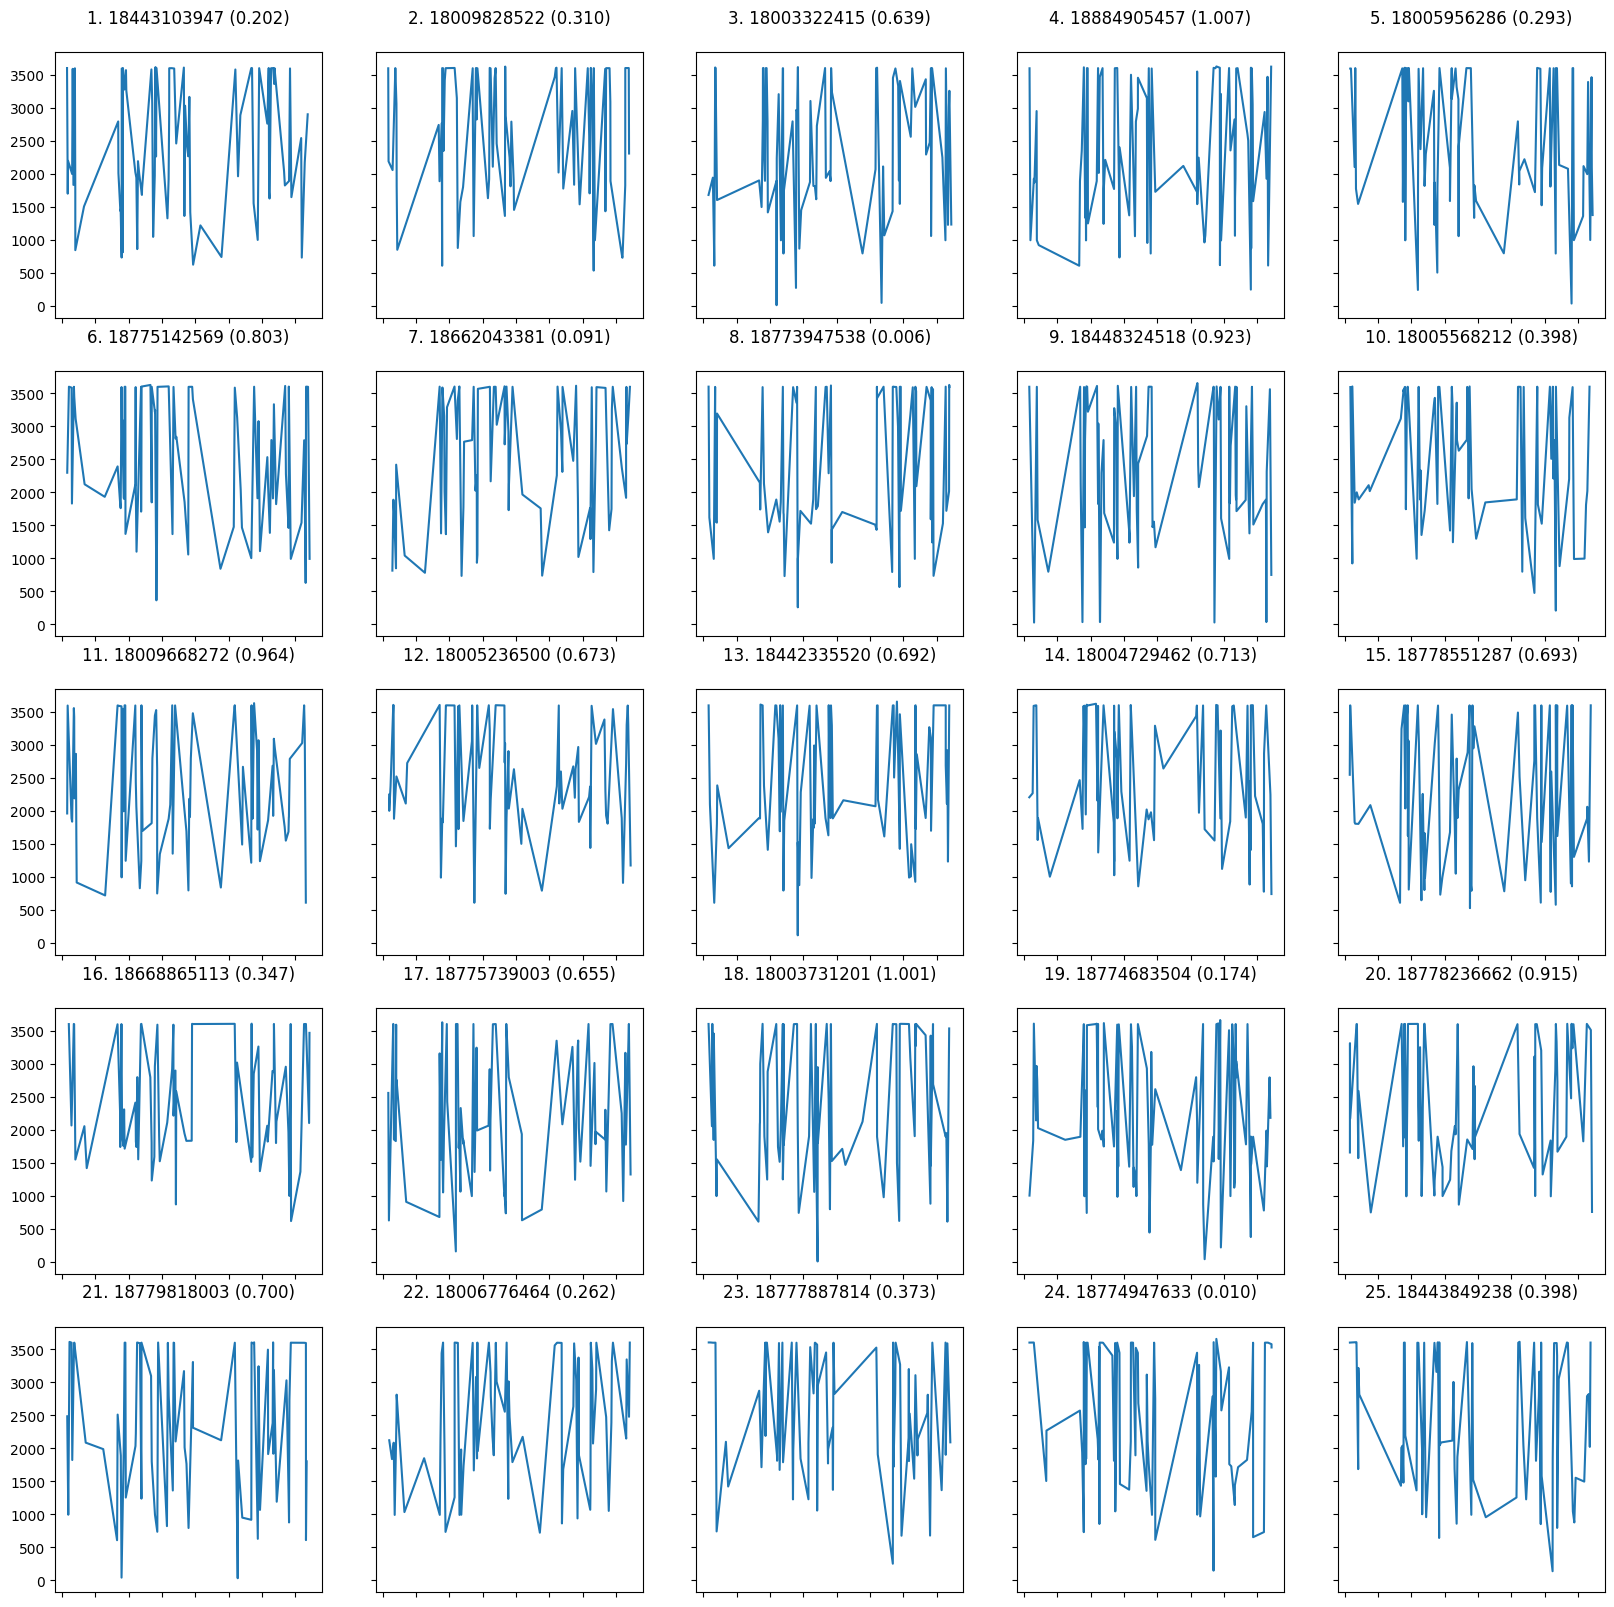

CPU times: user 4.54 s, sys: 36.3 ms, total: 4.57 s
Wall time: 4.59 s


In [147]:
%%time
indice = 0
plot_flat_ts(df, df_dest, ind=indice)

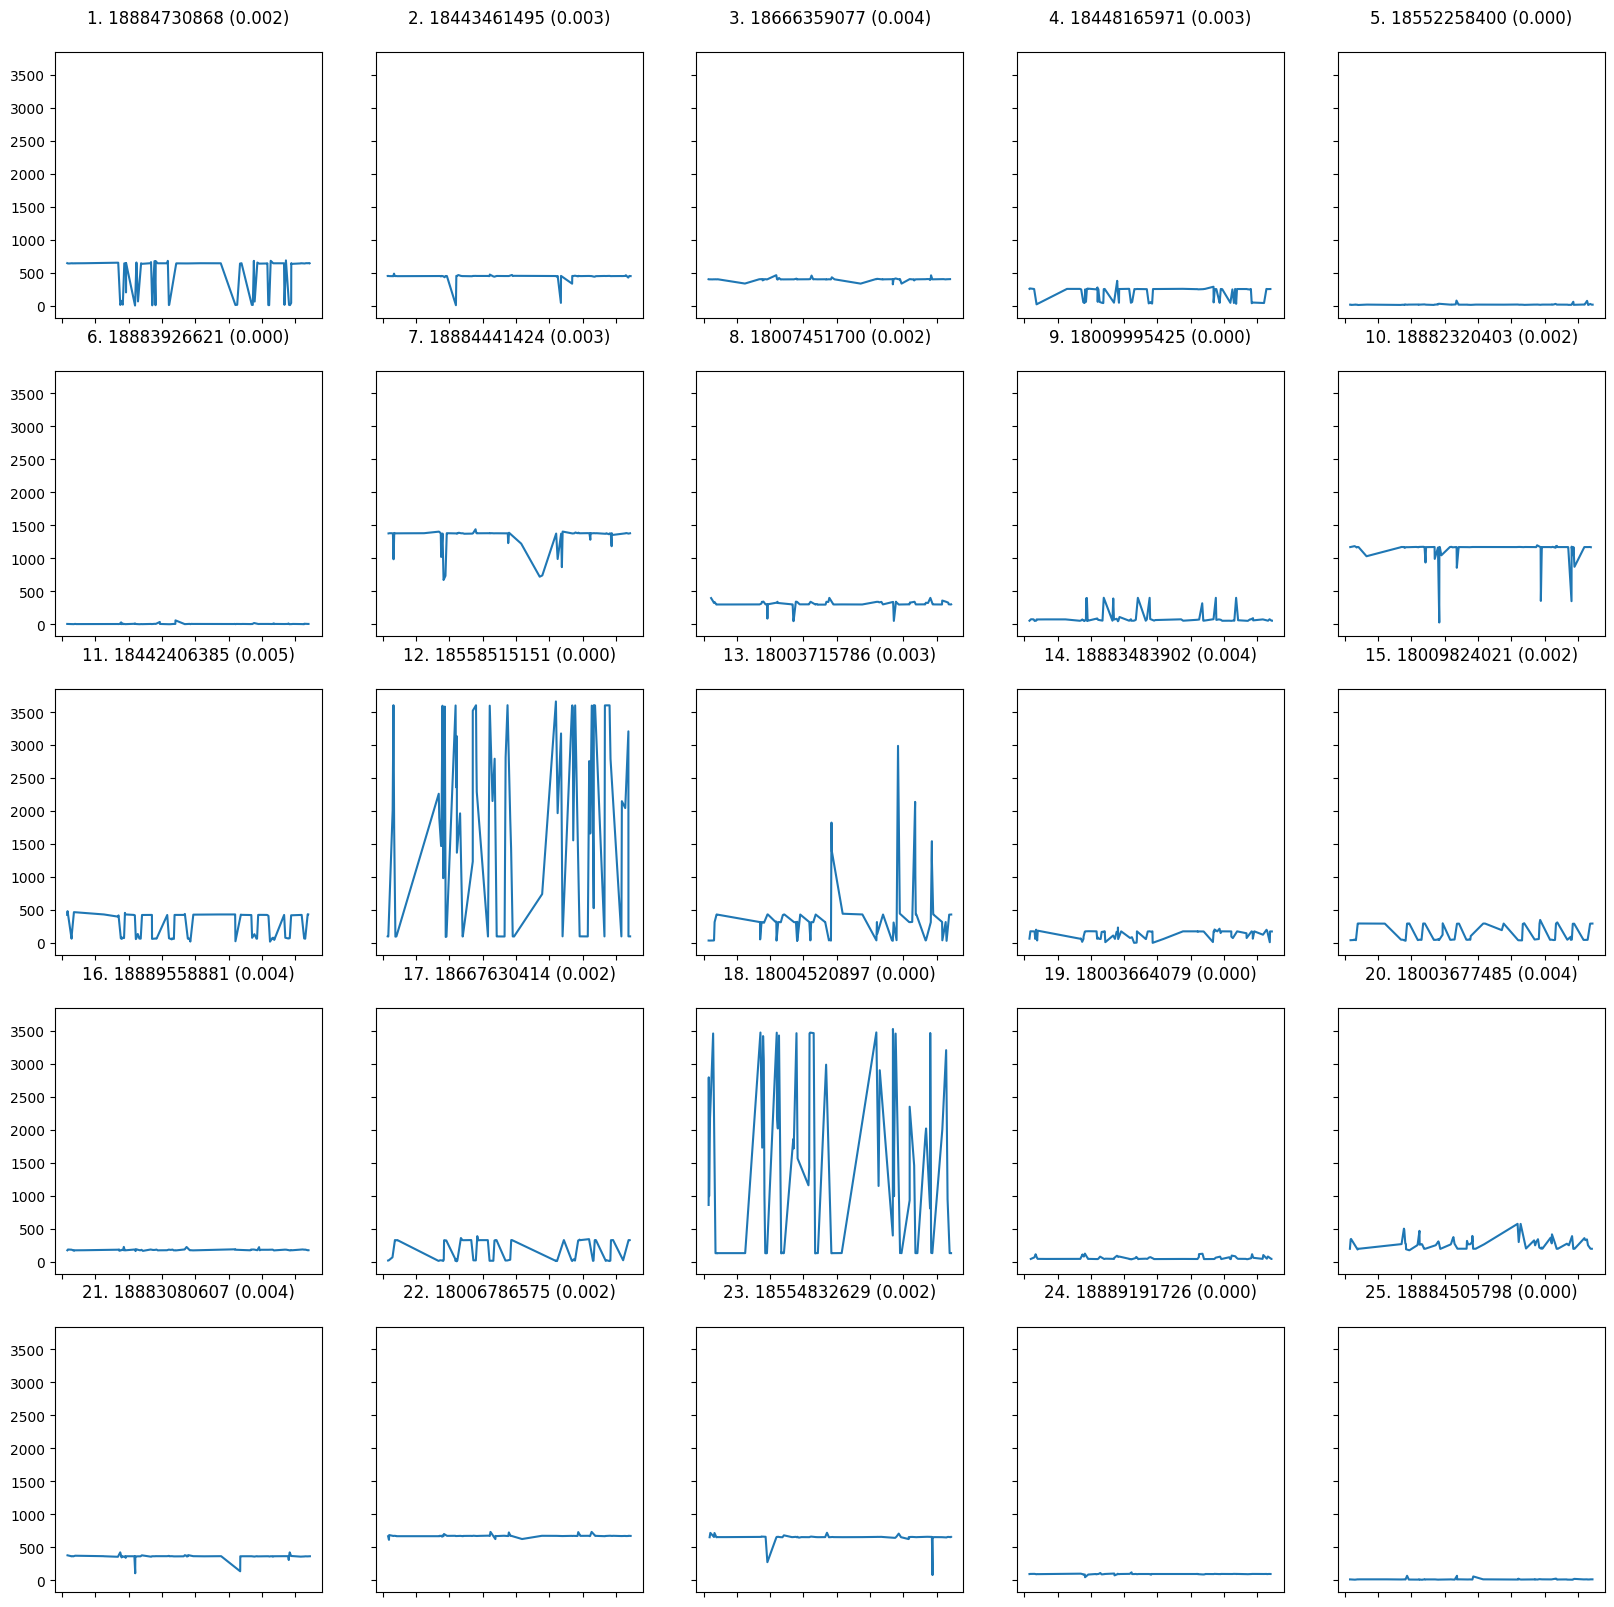

CPU times: user 4.24 s, sys: 22.1 ms, total: 4.26 s
Wall time: 4.26 s


In [148]:
%%time
plot_flat_ts(df, df_dest_flat, ind=indice)

In [149]:
index_lm[:20]

CategoricalIndex(['18884730868', '18443461495', '18666359077', '18448165971',
                  '18552258400', '18883926621', '18884441424', '18007451700',
                  '18009995425', '18882320403', '18442406385', '18558515151',
                  '18003715786', '18883483902', '18009824021', '18889558881',
                  '18667630414', '18004520897', '18003664079', '18003677485'],
                 categories=['18002001956', '18002002000', '18002002599', '18002002665', ..., '18889996569', '18889999101', '18889999353', '18889999520'], ordered=False, dtype='category', name='calledstation')

In [150]:
df_grafica = df[df.calledstation.isin(index_lm[i+indice*rows*cols:i+indice*rows*cols+rows*cols])]
df_grafica

,calledstation,real_sessiontime,bd,weekday,hour
starttime,,,,,
2023-09-15 07:00:12,18558515151,100,marcador_1,4,7
2023-09-15 07:04:47,18443461495,451,marcador_1,4,7
2023-09-15 07:12:49,18442406385,426,marcador_4,4,7
2023-09-15 07:13:51,18003677485,194,marcador_4,4,7
2023-09-15 07:17:27,18666359077,401,marcador_4,4,7
...,...,...,...,...,...
2023-09-29 21:05:10,18552258400,16,marcador_3,4,21
2023-09-29 21:06:00,18009995425,55,marcador_3,4,21
2023-09-29 21:09:09,18883080607,363,marcador_3,4,21


#### Comportamiento de llamadas en el tiempo

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187411 entries, 2023-09-15 07:00:03 to 2023-09-29 21:16:45
Data columns (total 5 columns):
 #   Column            Dtype   
---  ------            -----   
 0   calledstation     category
 1   real_sessiontime  int64   
 2   bd                category
 3   weekday           int32   
 4   hour              int32   
dtypes: category(2), int32(2), int64(1)
memory usage: 95.2 MB


<Axes: xlabel='hour'>

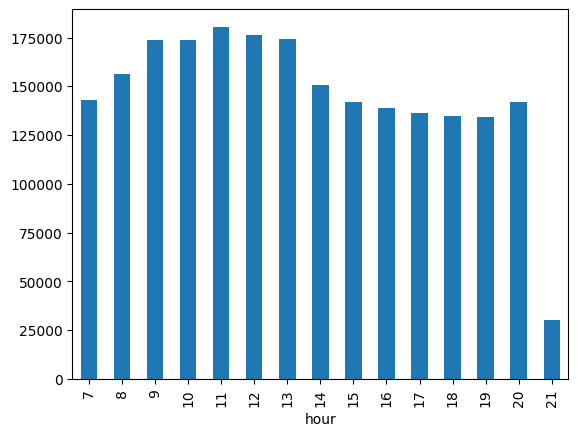

In [152]:
df.groupby('hour').count().calledstation.plot(kind='bar')

<Axes: xlabel='hour', ylabel='calledstation'>

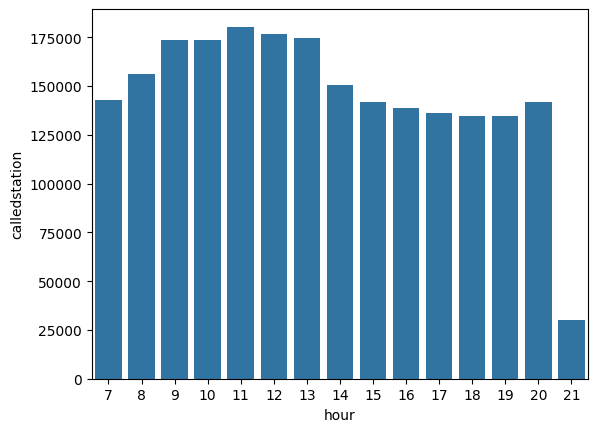

In [153]:
sns.barplot(data=df.groupby('hour').count(),
            x=df.groupby('hour').count().index,
            y='calledstation')

In [154]:
fig = px.bar(df.groupby('hour').count(), 
             x=df.groupby('hour').count().index, 
             y='calledstation')
fig.show()

<Axes: xlabel='weekday'>

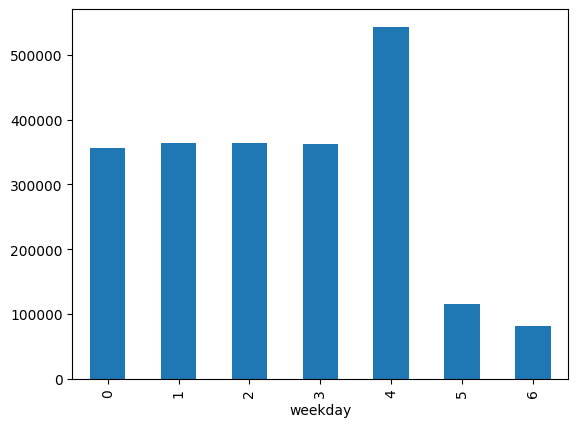

In [155]:
# lunes = 0, domingo = 6
df.groupby('weekday').count().calledstation.plot(kind='bar')

<Axes: xlabel='weekday', ylabel='calledstation'>

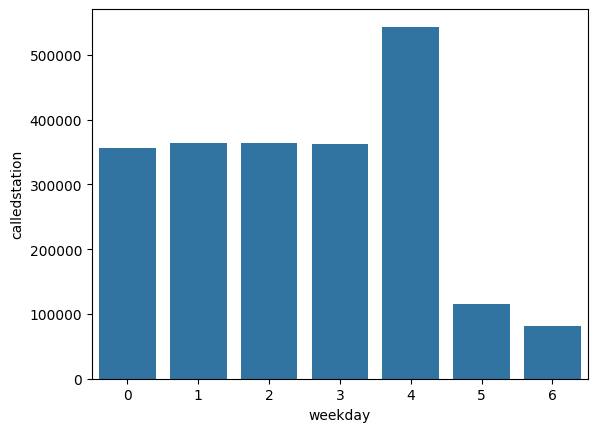

In [156]:
sns.barplot(data=df.groupby('weekday').count(),
            x=df.groupby('weekday').count().index,
            y='calledstation')

In [157]:
fig = px.bar(df.groupby('weekday').count(), 
             x=df.groupby('weekday').count().index, 
             y='calledstation')
fig.show()

#### Duración de llamadas en el tiempo

In [158]:
index_lm

CategoricalIndex(['18884730868', '18443461495', '18666359077', '18448165971',
                  '18552258400', '18883926621', '18884441424', '18007451700',
                  '18009995425', '18882320403',
                  ...
                  '18554054996', '18448634621', '18447361549', '18667271694',
                  '18772197340', '18448213248', '18007154836', '18448743833',
                  '18004036322', '18444786683'],
                 categories=['18002001956', '18002002000', '18002002599', '18002002665', ..., '18889996569', '18889999101', '18889999353', '18889999520'], ordered=False, dtype='category', name='calledstation', length=10512)

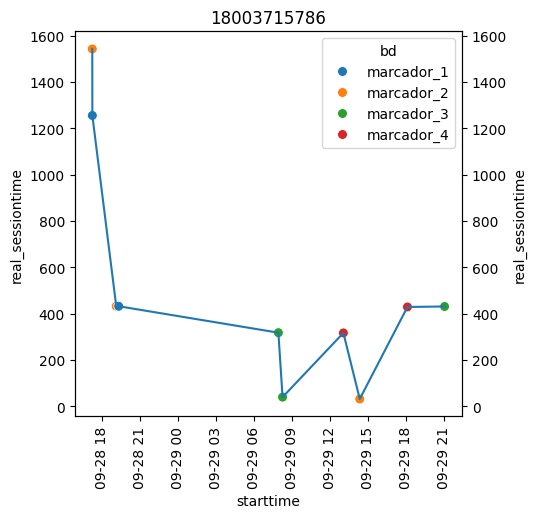

In [159]:
dest_num = '18003715786'
last_n=10

fix, ax1 = plt.subplots(figsize=(5,5))

plt.xticks(rotation='vertical')

sns.scatterplot(data = df[df.calledstation == dest_num].tail(last_n),
             x = df[df.calledstation == dest_num].tail(last_n).index,
             y = 'real_sessiontime',
             hue = 'bd',
             s=50,                         
             ax=ax1,
             )

ax2 = ax1.twinx()

sns.lineplot(data = df[df.calledstation == dest_num].tail(last_n),
             x = df[df.calledstation == dest_num].tail(last_n).index,
             y = 'real_sessiontime',
             ax=ax2,
             )

plt.title(f'{dest_num}')

plt.show()

In [160]:
df[df.calledstation == dest_num]

,calledstation,real_sessiontime,bd,weekday,hour
starttime,,,,,
2023-09-15 07:21:17,18003715786,37,marcador_4,4,7
2023-09-15 08:49:15,18003715786,36,marcador_2,4,8
2023-09-15 14:58:52,18003715786,38,marcador_3,4,14
2023-09-15 15:08:50,18003715786,42,marcador_2,4,15
2023-09-15 15:59:44,18003715786,316,marcador_3,4,15
...,...,...,...,...,...
2023-09-29 08:14:46,18003715786,40,marcador_3,4,8
2023-09-29 13:03:17,18003715786,317,marcador_4,4,13
2023-09-29 14:20:56,18003715786,32,marcador_2,4,14


In [161]:
low = len(df[df.calledstation == dest_num]) - 2
hi = len(df[df.calledstation == dest_num])
df[df.calledstation == dest_num].real_sessiontime.iloc[low:hi].std() / df[df.calledstation == dest_num].real_sessiontime.iloc[low:hi].mean()

np.float64(0.0032888687497048723)

#### Dispersión de duración de llamadas según frecuencia

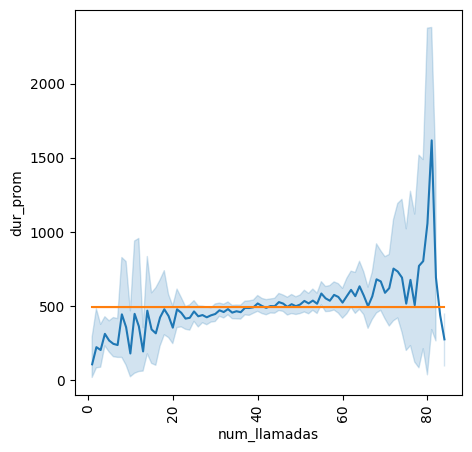

In [162]:
fix, ax1 = plt.subplots(figsize=(5,5))

plt.xticks(rotation='vertical')

sns.lineplot(data = df_dest,
             x = df_dest.num_llamadas,
             y = df_dest.dur_prom,
             errorbar=('ci', 100),
             ax=ax1,
             )

sns.lineplot(data = df_dest,
             x = df_dest.num_llamadas,
             y = df_dest.dur_prom.mean(),
             )


plt.show()


#### Frecuencia de número de llamadas

In [167]:
df_dest.num_llamadas.value_counts()

num_llamadas
38    1957
39    1915
35    1906
40    1893
36    1876
      ... 
81       6
80       4
82       3
84       2
83       1
Name: count, Length: 84, dtype: int64

<Axes: xlabel='num_llamadas'>

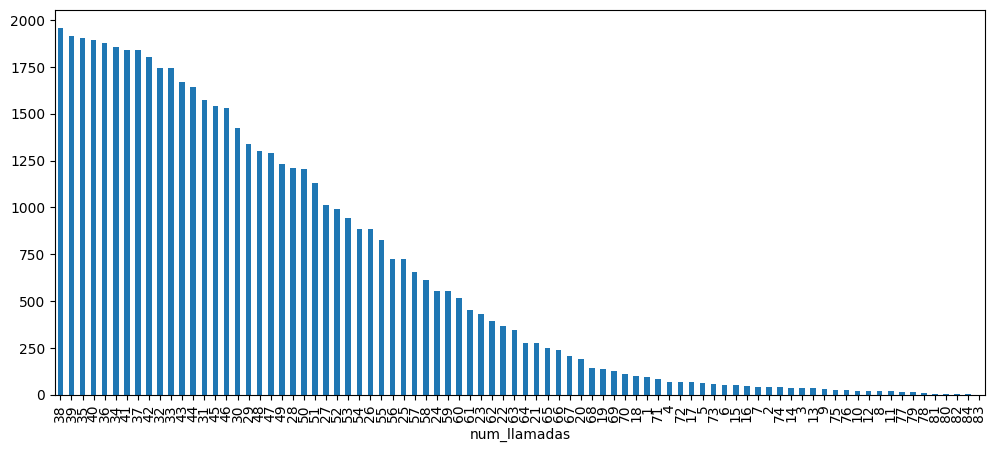

In [164]:
df_dest.num_llamadas.value_counts().plot(kind='bar', figsize=(12,5))

#### Histogramas

<Axes: >

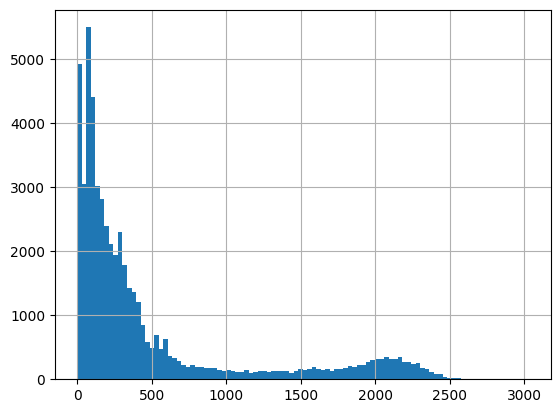

In [165]:
# por duraciones promedio
df_dest.dur_prom.hist(bins=100)

<Axes: >

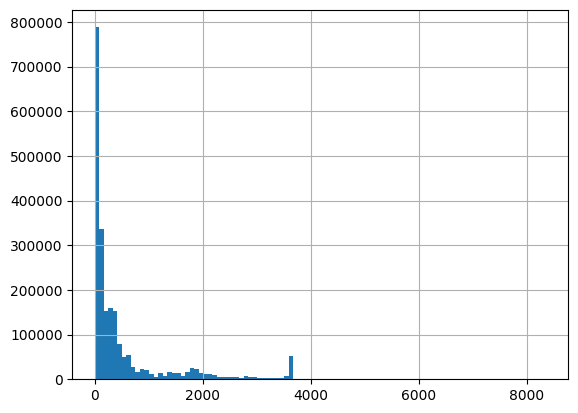

In [166]:
# por duraciones reales
df.real_sessiontime.hist(bins=100)